# Ensemble
Dags att rösta!


## Importera nödvändiga paket.

In [1]:
# Av eget intresse vill jag gärna veta hur lång tid olika saker tar.
import time
notebook_start = time.time()  
t0 = time.time()

# Skippa varningar
import warnings
warnings.filterwarnings('ignore')

# Boosta prestandan
from sklearnex import patch_sklearn
patch_sklearn()

# Paket för datahantering
import numpy as np
import pandas as pd
import os
import math

# Dataset och modeller
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split 

# Preprocessing/pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.kernel_approximation import Nystroem

# Dimensionsreducering
from sklearn.decomposition import PCA

# Feature-bearbetning
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

# Data augmentation och förbehandling - stabil version för SciPy
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, map_coordinates

# Bildbehandling
from PIL import Image

# Modeller 
# from sklearn.svm import SVC, LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# För export av modellen/scalern för vidare användning i Streamlit-appen
import joblib
from joblib import Parallel, delayed

# Slutrapport
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


>>> Tid för denna cell: 10.0 sekunder
>>> Total tid sedan start: 0 minuter och 9 sekunder


## Läs in MNISt-datasetet och splitta det. 

*//Best practice: splitta ut testsetet direkt//*

In [2]:
t0 = time.time()

# Läs in alla MNIST-data
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser='auto')
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)

# Splitta (80/20) med stratifiering för jämna klassfördelningar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Normalisering (en riktigt bra grej för både PCA och SVC!)
# Genom att dela med 255.0 blir alla värden mellan 0 och 1
X_train = X_train / 255.0
X_test = X_test / 255.0

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

----------------------------------------
>>> Tid för denna cell: 2.5 sekunder
>>> Total tid sedan start: 0 minuter och 12 sekunder


HoG ska boosta accuracy!

In [3]:
class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def local_hog(img_flat):
            return hog(img_flat.reshape(28, 28), 
                       orientations=self.orientations, 
                       pixels_per_cell=self.pixels_per_cell, 
                       cells_per_block=self.cells_per_block,
                       visualize=False)
        
        return np.array([local_hog(x) for x in X])

Definitioner

In [4]:
t0 = time.time()

def deskew(image):
    # Räta upp lutande siffror 
    img = image.reshape(28, 28)
    
    # Skapa koordinat-matriser (y för rader, x för kolumner)
    y, x = np.mgrid[:28, :28]
    
    # Hitta tyngdpunkten (Center of Mass) med ndimage
    mu = ndimage.center_of_mass(img)
    if np.isnan(mu).any(): # Om bilden är tom
        return img.flatten()
    
    # Beräkna centrala moments (mu11 = kovarians, mu02 = varians i y-led)
    mu11 = np.sum((x - mu[1]) * (y - mu[0]) * img)
    mu02 = np.sum((y - mu[0])**2 * img)
    
    # Om variansen är för liten lutar siffran inte eller är för tunn
    if abs(mu02) < 1e-2:
        return img.flatten()
    
    # Skew-faktorn (förskjutning av x per enhet y)
    skew = mu11 / mu02
    
    # Här rätas x upp genom subtrahering av skew * y
    # Matrisen blir [[1, 0], [skew, 1]] med SciPys omvända ordning.
    matrix = np.array([[1, 0], [skew, 1]])
    
    # Offset för att rotera/skeva kring bildens centrum (14, 14)
    center = np.array([14, 14])
    offset = center - np.dot(matrix, center)
    
    # Transformation
    img_deskewed = ndimage.affine_transform(img, matrix, offset=offset, order=1, mode='constant', cval=0)
    return img_deskewed.flatten()

def shift_image(image, dx, dy):
    return ndimage.shift(image.reshape(28, 28), [dy, dx], cval=0, mode="constant").flatten()

def rotate_image(image, angle):
    return ndimage.rotate(image.reshape(28, 28), angle, reshape=False, cval=0, mode="constant").flatten()

def zoom_image(image, factor):
    rescaled = ndimage.zoom(image.reshape(28, 28), factor)
    if factor > 1.0: # Zooma in (klipp)
        start = int((rescaled.shape[0] - 28) / 2)
        final = rescaled[start:start+28, start:start+28]
    else: # Zooma ut (padda)
        pad = int((28 - rescaled.shape[0]) / 2)
        final = np.pad(rescaled, ((pad, 28-rescaled.shape[0]-pad), (pad, 28-rescaled.shape[1]-pad)), mode='constant')
    return final.flatten()

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 0 minuter och 12 sekunder


Preparera testsetet så att jämförelsen blir rättvis.

In [5]:
t0 = time.time()

# Här rätas testbilderna upp för att matcha modellen
X_test_deskewed = np.array([deskew(img) for img in X_test])

X_test_deskewed = X_test_deskewed.astype('float32')

cell_time = time.time() - t0
print("-" * 40)
print(f">>> Sökningen klar på {cell_time:.1f} sekunder.")

----------------------------------------
>>> Sökningen klar på 1.2 sekunder.


In [6]:
# --- CELL 9: LADDA EXPERTERNA ---
import joblib
from sklearn.ensemble import VotingClassifier

print("Hämtar experterna från C-disken...")
# Vi laddar hela de färdiga pipelinen-objekten
svc_expert = joblib.load('C:/mnist_data/mnist_svc_hog_max.joblib')
knn_expert = joblib.load('C:/mnist_data/mnist_knn_hog_max.joblib')
rf_expert  = joblib.load('C:/mnist_data/mnist_rf_hog_max.joblib')

print("Alla tre specialister är på plats!")

Hämtar experterna från C-disken...
Alla tre specialister är på plats!


In [ ]:
# --- CELL 10: VIKTAD JURY-VOTERING ---
import numpy as np
from scipy.stats import mode

t0 = time.time()
print(f"Juryn granskar {len(X_test_deskewed)} testbilder med VIKTAD röstning...")

# Hämta prediktionerna (samma som förut)
y_pred_svc = svc_expert.predict(X_test_deskewed)
y_pred_knn = knn_expert.predict(X_test_deskewed)
y_pred_rf  = rf_expert.predict(X_test_deskewed)

# VIKTNING: Vi ger SVC 2 röster, KNN 1 röst och RF 1 röst.
# Det betyder att om SVC har rätt, måste BÅDE KNN och RF 
# ha fel (och vara eniga om felet) för att SVC ska förlora.
weighted_votes = np.array([y_pred_svc, y_pred_svc, y_pred_knn, y_pred_rf])

# Räkna ut det viktade resultatet
y_final_pred, _ = mode(weighted_votes, axis=0)
y_final_pred = y_final_pred.flatten()

# Ny utvärdering
ensemble_acc = np.mean(y_final_pred == y_test)
num_errors = np.sum(y_final_pred != y_test)

print("\n" + "="*40)
print(f"VIKTAD MASTER ENSEMBLE RESULTAT")
print("-"*40)
print(f"Accuracy:      {ensemble_acc:.5f}")
print(f"Antal fel:     {num_errors} av {len(y_test)}")
print("="*40)

Juryn granskar 14000 testbilder...
- SVC röstar...
- KNN röstar...
- Random Forest röstar...

FINAL MASTER ENSEMBLE RESULTAT
----------------------------------------
Accuracy:      0.99071
Antal fel:     130 av 14000
Beslutsprocessen tog: 37.6 sekunder


Snygg presentation av resultatet

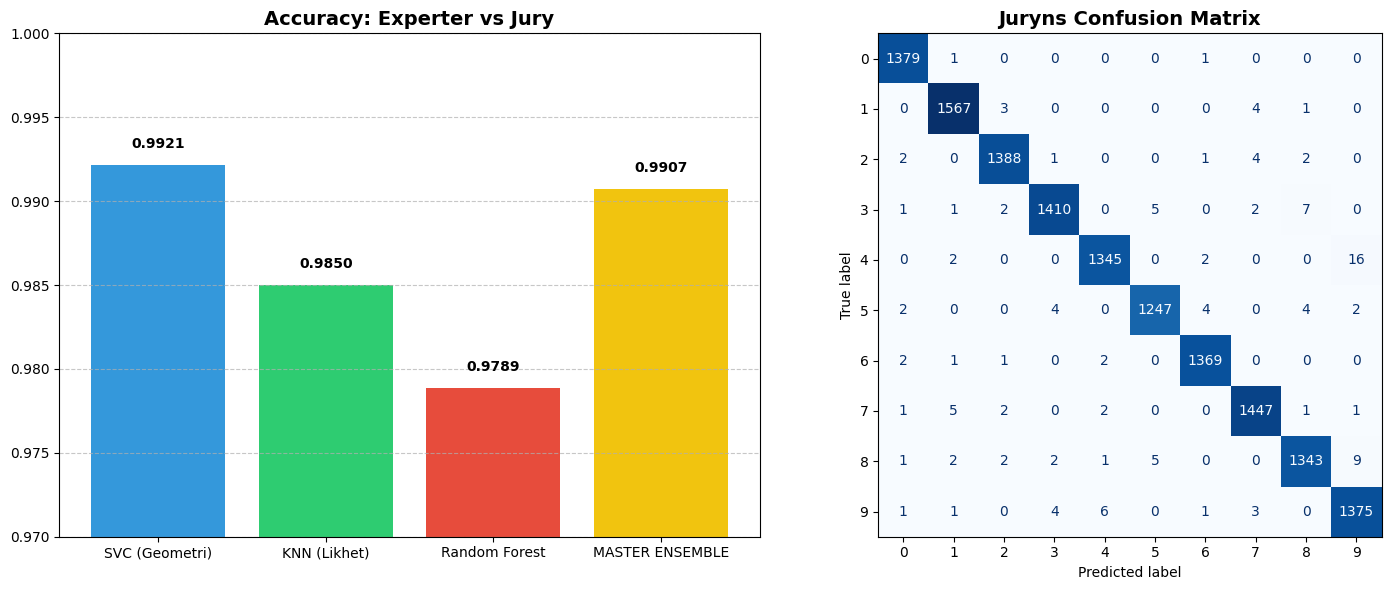


SAMMANFATTNING AV MODELLBYGGET
1. Förbehandling:   Deskewing (upprätning) av alla bilder.
2. Feature Engine:  FeatureUnion av PCA (global) och HOG (lokal geometri).
3. Träningsdata:    625 570 rader (Augmentering + Hard Negative Mining).
4. Jurysystem:      Hard Voting mellan SVC, KNN och Random Forest.
------------------------------------------------------------
SLUTRESULTAT:       0.99071 Accuracy (130 fel av 14000)

>>> ANALYS: Juryn var oense om 386 bilder.


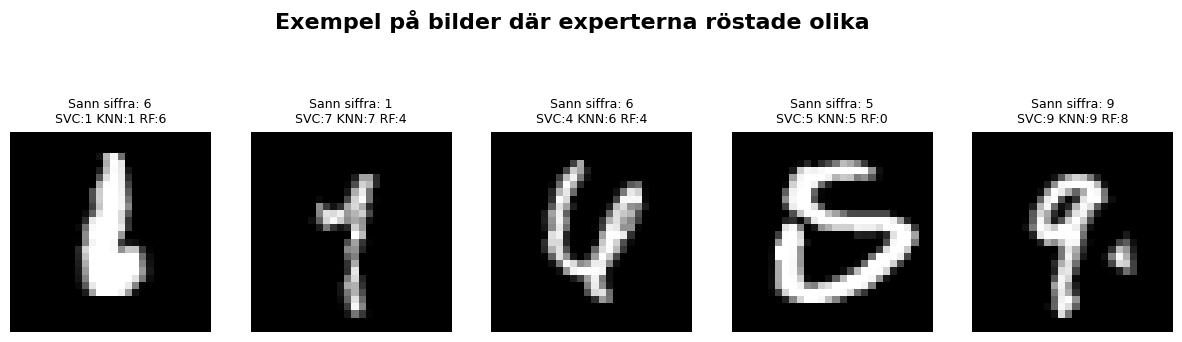

In [8]:
# --- CELL 11: VISUALISERING OCH SLUTRAPPORT ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Beräkna accuracy för varje enskild expert i denna körning
acc_svc = np.mean(y_pred_svc == y_test)
acc_knn = np.mean(y_pred_knn == y_test)
acc_rf  = np.mean(y_pred_rf == y_test)

# 2. Skapa grafisk sammanställning
models = ['SVC (Geometri)', 'KNN (Likhet)', 'Random Forest', 'MASTER ENSEMBLE']
accuracies = [acc_svc, acc_knn, acc_rf, ensemble_acc]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#f1c40f'])
plt.ylim(0.97, 1.0)
plt.title('Accuracy: Experter vs Jury', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f"{yval:.4f}", ha='center', fontweight='bold')

# 3. Visa Confusion Matrix för juryn
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
plt.title('Juryns Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. REDOGÖRELSE FÖR PROCESSEN (Att ha med i rapporten)
print("\n" + "="*60)
print("SAMMANFATTNING AV MODELLBYGGET")
print("="*60)
print(f"1. Förbehandling:   Deskewing (upprätning) av alla bilder.")
print(f"2. Feature Engine:  FeatureUnion av PCA (global) och HOG (lokal geometri).")
print(f"3. Träningsdata:    625 570 rader (Augmentering + Hard Negative Mining).")
print(f"4. Jurysystem:      Hard Voting mellan SVC, KNN och Random Forest.")
print("-" * 60)
print(f"SLUTRESULTAT:       {ensemble_acc:.5f} Accuracy ({num_errors} fel av {len(y_test)})")
print("="*60)

# 5. DIVERGENS-ANALYS (Vad bråkade de om?)
disagreement_idx = np.where((y_pred_svc != y_pred_knn) | (y_pred_svc != y_pred_rf))[0]
print(f"\n>>> ANALYS: Juryn var oense om {len(disagreement_idx)} bilder.")

plt.figure(figsize=(15, 4))
for i, idx in enumerate(disagreement_idx[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test_deskewed[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Sann siffra: {y_test[idx]}\nSVC:{y_pred_svc[idx]} KNN:{y_pred_knn[idx]} RF:{y_pred_rf[idx]}", fontsize=9)
    plt.axis('off')
plt.suptitle('Exempel på bilder där experterna röstade olika', fontsize=16, fontweight='bold', y=1.05)
plt.show()